In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cods.od.data import MSCOCODataset
from cods.od.models import YOLOModel, DETRModel
import logging
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "1"  # chose the GPU. If only one, then "0"
)

logging.getLogger().setLevel(logging.INFO)

In [3]:
# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

In [4]:
calibration_ratio = (
    0.5  # set 0.5 to use 50% for calibration and 50% for testing
)

use_smaller_subset = True  # TODO: Temp

if use_smaller_subset:
    data_cal, data_val = data.split_dataset(
        calibration_ratio, shuffle=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.split_dataset(calibration_ratio, shuffle=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
model_detr = DETRModel(model_name="detr_resnet50", pretrained=True, device="cpu")
model_yolo = YOLOModel(model_name="yolov8x.pt", pretrained=True, device="cpu")


print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 400
len(data_val) = 400


In [5]:
def filter_preds(preds, confidence_threshold=0.001):
    filters = [
        conf > confidence_threshold
        if (conf > confidence_threshold).any()
        else conf.argmin(0)[None]
        for conf in preds.confidences
    ]
    preds.pred_boxes = [pbs[f] for pbs, f in zip(preds.pred_boxes, filters)]
    preds.pred_cls = [pcs[f] for pcs, f in zip(preds.pred_cls, filters)]
    preds.confidences = [
        conf[f] for conf, f in zip(preds.confidences, filters)
    ]
    return preds

In [31]:
def compute_statistics(model, confidence_threshold, verbose=False):
    preds_cal = model.build_predictions(
        data_cal,
        dataset_name="mscoco",
        split_name="cal",
        batch_size=12,
        collate_fn=data._collate_fn,  # TODO: make this a default for COCO
        shuffle=False,
        force_recompute=False,  # False,
        deletion_method="nms",
        verbose=False,
    )
    nb_true_boxes = sum([len(x) for x in preds_cal.true_boxes]) / len(preds_cal.true_boxes)
    nb_pred_boxes = sum([len(x) for x in preds_cal.pred_boxes]) / len(preds_cal.pred_boxes)
    max_true_boxes = max([len(x) for x in preds_cal.true_boxes])
    max_pred_boxes = max([len(x) for x in preds_cal.pred_boxes])
    min_true_boxes = min([len(x) for x in preds_cal.true_boxes])
    min_pred_boxes = min([len(x) for x in preds_cal.pred_boxes])
    fifth_quantile_true_boxes = np.percentile([len(x) for x in preds_cal.true_boxes], 5)
    fifth_quantile_pred_boxes = np.percentile([len(x) for x in preds_cal.pred_boxes], 5)
    ninetyfifth_quantile_true_boxes = np.percentile([len(x) for x in preds_cal.true_boxes], 95)
    ninetyfifth_quantile_pred_boxes = np.percentile([len(x) for x in preds_cal.pred_boxes], 95)

    preds_cal = filter_preds(preds_cal, confidence_threshold)

    nb_pred_boxes_filtered = sum([len(x) for x in preds_cal.pred_boxes]) / len(preds_cal.pred_boxes)
    max_pred_boxes_filtered = max([len(x) for x in preds_cal.pred_boxes])
    min_pred_boxes_filtered = min([len(x) for x in preds_cal.pred_boxes])
    fifth_quantile_pred_boxes_filtered = np.percentile([len(x) for x in preds_cal.pred_boxes], 5)
    ninetyfifth_quantile_pred_boxes_filtered = np.percentile([len(x) for x in preds_cal.pred_boxes], 95)

    if verbose:
        # Print this all neatly in a comparison
        # Print model name and parameters
        print(f"{'Model':<20}{model.model_name:<20}")
        print(f"{'Confidence thresh.':<20}{confidence_threshold:<20}")
        print(f"{'':<20}{'Before':<20}{'After':<20}")
        print(f"{'nb_true_boxes':<20}{nb_true_boxes:<20}{nb_true_boxes:<20}")
        print(f"{'nb_pred_boxes':<20}{nb_pred_boxes:<20}{nb_pred_boxes_filtered:<20}")
        print(f"{'max_true_boxes':<20}{max_true_boxes:<20}{max_true_boxes:<20}")
        print(f"{'max_pred_boxes':<20}{max_pred_boxes:<20}{max_pred_boxes_filtered:<20}")
        print(f"{'min_true_boxes':<20}{min_true_boxes:<20}{min_true_boxes:<20}")
        print(f"{'min_pred_boxes':<20}{min_pred_boxes:<20}{min_pred_boxes_filtered:<20}")
        print(f"{'5th quantile true':<20}{fifth_quantile_true_boxes:<20}{fifth_quantile_true_boxes:<20}")
        print(f"{'5th quantile pred':<20}{fifth_quantile_pred_boxes:<20}{fifth_quantile_pred_boxes_filtered:<20}")
        print(f"{'95th quantile true':<20}{ninetyfifth_quantile_true_boxes:<20}{ninetyfifth_quantile_true_boxes:<20}")
        print(f"{'95th quantile pred':<20}{ninetyfifth_quantile_pred_boxes:<20}{ninetyfifth_quantile_pred_boxes_filtered:<20}")
        print("\n")

    results = {
        "model_name": model.model_name,
        "confidence_threshold": confidence_threshold,
        "nb_true_boxes": nb_true_boxes,
        "nb_pred_boxes": nb_pred_boxes,
        "max_true_boxes": max_true_boxes,
        "max_pred_boxes": max_pred_boxes,
        "min_true_boxes": min_true_boxes,
        "min_pred_boxes": min_pred_boxes,
        "nb_pred_boxes_filtered": nb_pred_boxes_filtered,
        "max_pred_boxes_filtered": max_pred_boxes_filtered,
        "min_pred_boxes_filtered": min_pred_boxes_filtered,
        "fifth_quantile_true_boxes": fifth_quantile_true_boxes,
        "fifth_quantile_pred_boxes": fifth_quantile_pred_boxes,
        "fifth_quantile_pred_boxes_filtered": fifth_quantile_pred_boxes_filtered,
        "ninetyfifth_quantile_true_boxes": ninetyfifth_quantile_true_boxes,
        "ninetyfifth_quantile_pred_boxes": ninetyfifth_quantile_pred_boxes,
        "ninetyfifth_quantile_pred_boxes_filtered": ninetyfifth_quantile_pred_boxes_filtered,
    }
    return results

In [32]:
for conf in [1e-3, 1e-2, 1e-1]:
    compute_statistics(model_detr, conf, verbose=True)
    compute_statistics(model_yolo, conf, verbose=True)

In [45]:
from unittest import result


results_yolo_avg = []
results_detr_avg = []
results_detr_min = []
results_detr_max = []
results_yolo_min = []
results_yolo_max = []
results_true_avg = []
results_true_min = []
results_true_max = []
results_yolo_fifth = []
results_detr_fifth = []
results_yolo_ninetyfifth = []
results_detr_ninetyfifth = []
results_true_fifth = []
results_true_ninetyfifth = []

confs = [0, 1e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 0.95]

for conf in confs:
    results_detr = compute_statistics(model_detr, conf)
    results_yolo = compute_statistics(model_yolo, conf)
    results_detr_avg.append(results_detr["nb_pred_boxes_filtered"])
    results_detr_min.append(results_detr["min_pred_boxes_filtered"])
    results_detr_max.append(results_detr["max_pred_boxes_filtered"])
    results_yolo_avg.append(results_yolo["nb_pred_boxes_filtered"])
    results_yolo_min.append(results_yolo["min_pred_boxes_filtered"])
    results_yolo_max.append(results_yolo["max_pred_boxes_filtered"])
    results_yolo_fifth.append(results_yolo["fifth_quantile_pred_boxes_filtered"])
    results_detr_fifth.append(results_detr["fifth_quantile_pred_boxes_filtered"])
    results_yolo_ninetyfifth.append(results_yolo["ninetyfifth_quantile_pred_boxes_filtered"])
    results_detr_ninetyfifth.append(results_detr["ninetyfifth_quantile_pred_boxes_filtered"])

results_true_avg = results_detr["nb_true_boxes"]
results_true_min.append(results_detr["min_true_boxes"])
results_true_max.append(results_detr["max_true_boxes"])
results_true_fifth.append(results_detr["fifth_quantile_true_boxes"])
results_true_ninetyfifth.append(results_detr["ninetyfifth_quantile_true_boxes"])

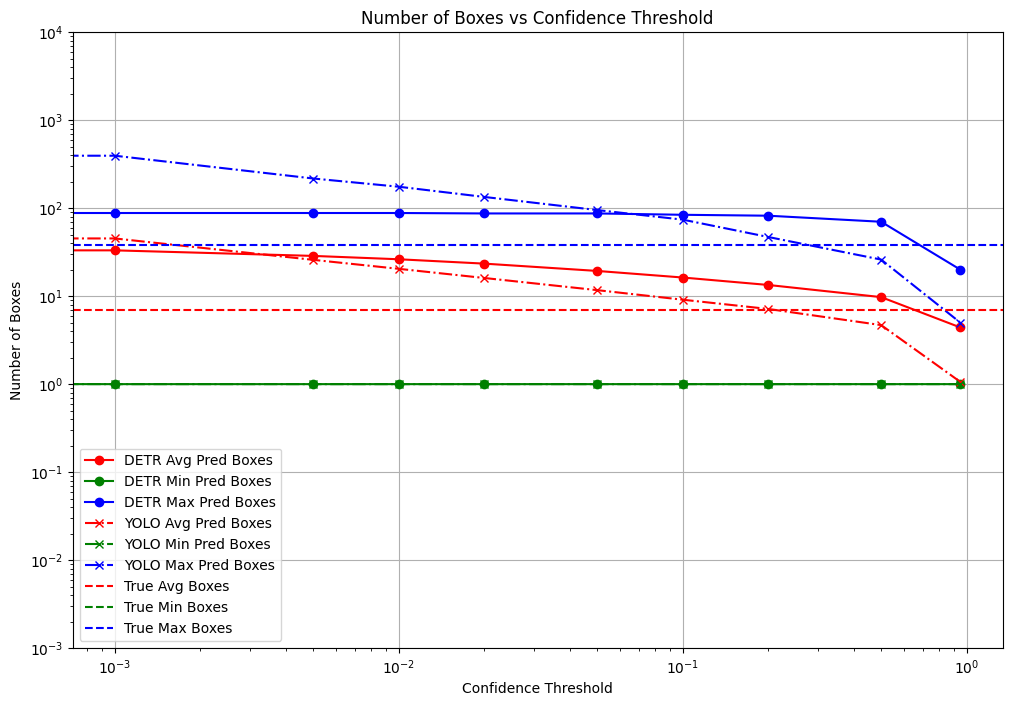

In [46]:
plt.figure(figsize=(12, 8))

plt.plot(confs, results_detr_avg, label='DETR Avg Pred Boxes', marker='o', color="r")
plt.plot(confs, results_detr_min, label='DETR Min Pred Boxes', marker='o', color="g")
plt.plot(confs, results_detr_max, label='DETR Max Pred Boxes', marker='o', color="b")

plt.plot(confs, results_yolo_avg, label='YOLO Avg Pred Boxes', marker='x', color="r", linestyle="dashdot")
plt.plot(confs, results_yolo_min, label='YOLO Min Pred Boxes', marker='x', color="g", linestyle="dashdot")
plt.plot(confs, results_yolo_max, label='YOLO Max Pred Boxes', marker='x', color="b", linestyle="dashdot")

plt.axhline(y=results_true_avg, color='r', linestyle='--', label='True Avg Boxes')
plt.axhline(y=results_true_min[0], color='g', linestyle='--', label='True Min Boxes')
plt.axhline(y=results_true_max[0], color='b', linestyle='--', label='True Max Boxes')

plt.xlabel('Confidence Threshold')
plt.ylabel('Number of Boxes')
plt.title('Number of Boxes vs Confidence Threshold')
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-3, 1e4)
plt.legend()
plt.grid(True)
plt.show()

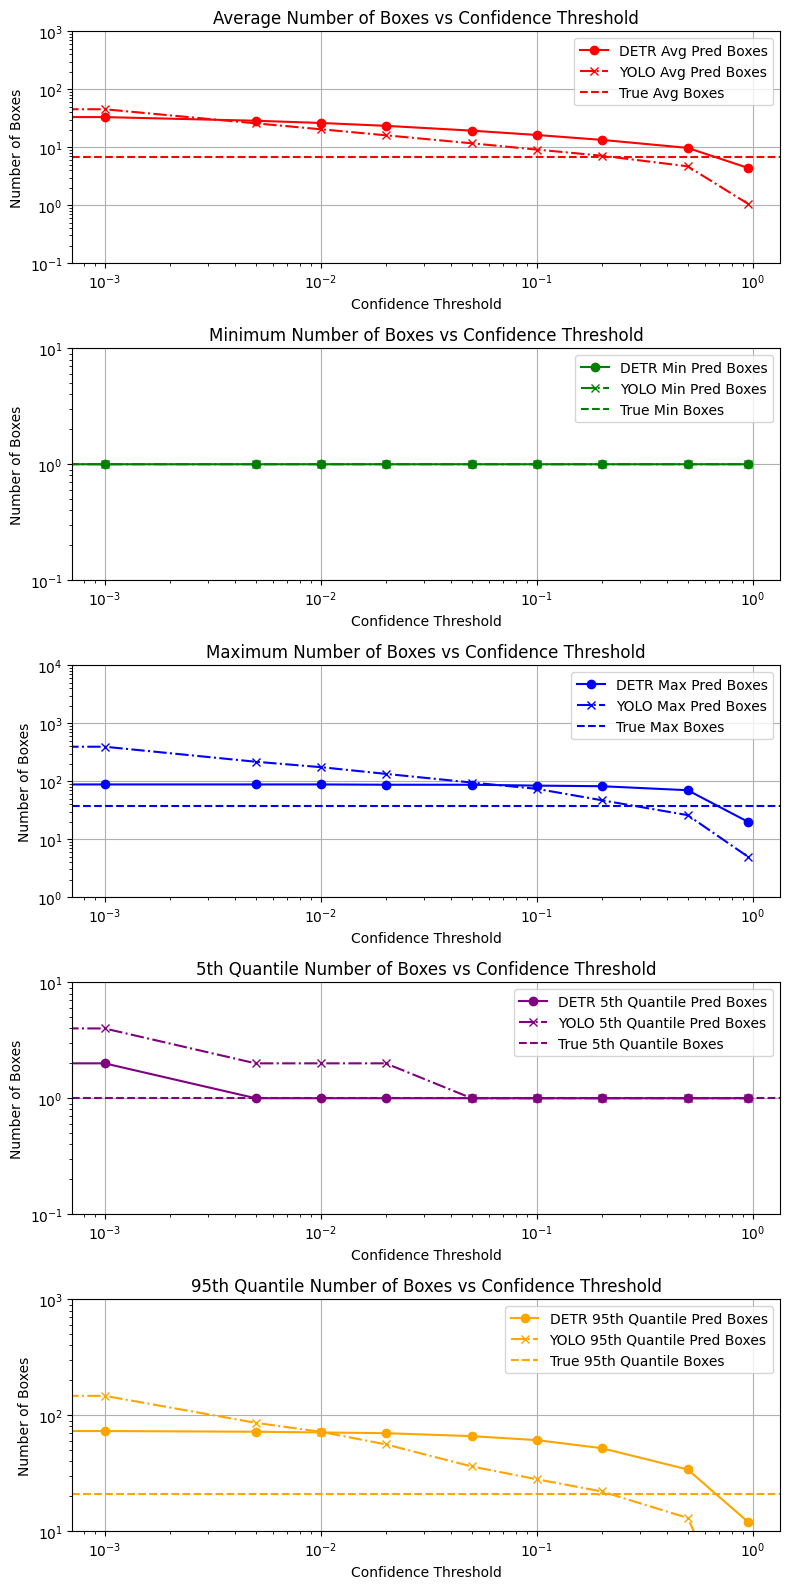

In [47]:
fig, axs = plt.subplots(5, 1, figsize=(8, 16))

# Plot average number of boxes
axs[0].plot(confs, results_detr_avg, label='DETR Avg Pred Boxes', marker='o', color="r")
axs[0].plot(confs, results_yolo_avg, label='YOLO Avg Pred Boxes', marker='x', color="r", linestyle="dashdot")
axs[0].axhline(y=results_true_avg, color='r', linestyle='--', label='True Avg Boxes')
axs[0].set_xlabel('Confidence Threshold')
axs[0].set_ylabel('Number of Boxes')
axs[0].set_title('Average Number of Boxes vs Confidence Threshold')
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_ylim(1e-1, 1e3)
axs[0].legend()
axs[0].grid(True)

# Plot minimum number of boxes
axs[1].plot(confs, results_detr_min, label='DETR Min Pred Boxes', marker='o', color="g")
axs[1].plot(confs, results_yolo_min, label='YOLO Min Pred Boxes', marker='x', color="g", linestyle="dashdot")
axs[1].axhline(y=results_true_min[0], color='g', linestyle='--', label='True Min Boxes')
axs[1].set_xlabel('Confidence Threshold')
axs[1].set_ylabel('Number of Boxes')
axs[1].set_title('Minimum Number of Boxes vs Confidence Threshold')
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_ylim(1e-1, 1e1)
axs[1].legend()
axs[1].grid(True)

# Plot maximum number of boxes
axs[2].plot(confs, results_detr_max, label='DETR Max Pred Boxes', marker='o', color="b")
axs[2].plot(confs, results_yolo_max, label='YOLO Max Pred Boxes', marker='x', color="b", linestyle="dashdot")
axs[2].axhline(y=results_true_max[0], color='b', linestyle='--', label='True Max Boxes')
axs[2].set_xlabel('Confidence Threshold')
axs[2].set_ylabel('Number of Boxes')
axs[2].set_title('Maximum Number of Boxes vs Confidence Threshold')
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_ylim(1e0, 1e4)
axs[2].legend()
axs[2].grid(True)

# Plot 5th quantile number of boxes
axs[3].plot(confs, results_detr_fifth, label='DETR 5th Quantile Pred Boxes', marker='o', color="purple")
axs[3].plot(confs, results_yolo_fifth, label='YOLO 5th Quantile Pred Boxes', marker='x', color="purple", linestyle="dashdot")
axs[3].axhline(y=results_true_fifth[0], color='purple', linestyle='--', label='True 5th Quantile Boxes')
axs[3].set_xlabel('Confidence Threshold')
axs[3].set_ylabel('Number of Boxes')
axs[3].set_title('5th Quantile Number of Boxes vs Confidence Threshold')
axs[3].set_xscale("log")
axs[3].set_yscale("log")
axs[3].set_ylim(1e-1, 1e1)
axs[3].legend()
axs[3].grid(True)

# Plot 95th quantile number of boxes
axs[4].plot(confs, results_detr_ninetyfifth, label='DETR 95th Quantile Pred Boxes', marker='o', color="orange")
axs[4].plot(confs, results_yolo_ninetyfifth, label='YOLO 95th Quantile Pred Boxes', marker='x', color="orange", linestyle="dashdot")
axs[4].axhline(y=results_true_ninetyfifth[0], color='orange', linestyle='--', label='True 95th Quantile Boxes')
axs[4].set_xlabel('Confidence Threshold')
axs[4].set_ylabel('Number of Boxes')
axs[4].set_title('95th Quantile Number of Boxes vs Confidence Threshold')
axs[4].set_xscale("log")
axs[4].set_yscale("log")
axs[4].set_ylim(1e1, 1e3)
axs[4].legend()
axs[4].grid(True)

plt.tight_layout()
plt.show()